In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
!ls

LICENSE		    env.yml	  notebooks
README.md	    env_norl.yml  prices_and_soc_over_episode.png
algo_comp_2019.png  examples	  reward_over_epsiode.png
algo_comp_2021.png  mypy.ini	  sustaingym


In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv



from sustaingym.envs.battery.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv
from sustaingym.envs.battery.plot_utils import plot_model_training_reward_curves, plot_reward_distribution, plot_state_of_charge_and_prices, plot_reward_over_episode

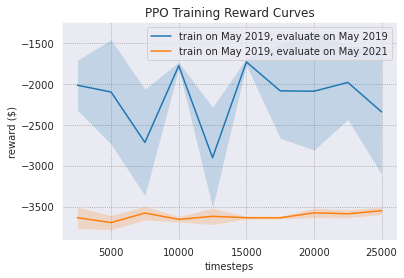

In [5]:
ax = plot_model_training_reward_curves(None, 'PPO', ['in_dist', 'out_dist'])

plt.savefig('examples/logs_PPO/ppo_reward_curves.png', dpi=300)

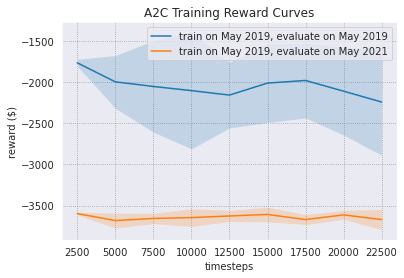

In [6]:
ax = plot_model_training_reward_curves(None, 'A2C', ['in_dist', 'out_dist'])

plt.savefig('examples/logs_A2C/a2c_reward_curves.png', dpi=300)

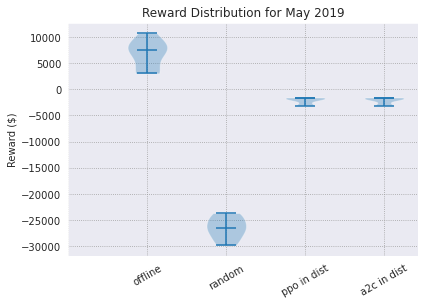

In [12]:
env_2019 = BatteryStorageInGridEnv(month='2019-05', seed=195)

ppo = PPO.load('examples/model_2019_5.zip')
a2c = A2C.load('examples/model_A2C_2019_5.zip')

ax = plot_reward_distribution(None, env_2019, [ppo, a2c],
    ['ppo in dist', 'a2c in dist'], 10, '2019')

plt.xticks(rotation=30)

plt.savefig('algo_comp_2019.png', dpi=300)



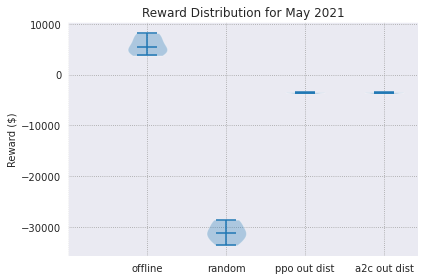

In [13]:
env_2021 = BatteryStorageInGridEnv(month='2021-05', seed=215)

ppo = PPO.load('examples/model_2019_5.zip')
a2c = A2C.load('examples/model_A2C_2019_5.zip')

ax = plot_reward_distribution(None, env_2021, [ppo, a2c],
    ['ppo out dist', 'a2c out dist'], 10, '2021')

plt.savefig('algo_comp_2021.png', dpi=300)

[6.00000000e+01 5.58333321e+01 5.16666641e+01 4.74999962e+01
 4.33333282e+01 3.91666603e+01 3.49999924e+01 3.08333263e+01
 2.66666603e+01 2.24999943e+01 1.83333282e+01 1.41666613e+01
 9.99999428e+00 5.83332777e+00 1.66666114e+00 3.97367366e-08
 0.00000000e+00 5.24157540e-15 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.79747796e-11 0.00000000e+00 0.00000000e+00
 1.20781003e-13 0.00000000e+00 0.00000000e+00 2.03374752e-13
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.97906995e-13 0.00000000e+00 4.78417111e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.67831752e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.62973106e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.74327956e-13 0.00000000e+00 3.34106630e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.67512032e-13 0.000000

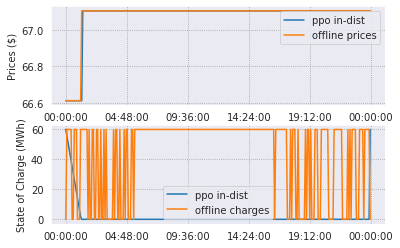

In [7]:
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

df_load = pd.read_csv('sustaingym/data/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)

env = BatteryStorageInGridEnv(month='2019-05', seed=195)
ppo = PPO.load('examples/model_2019_5.zip')

ax, ax2 = plot_state_of_charge_and_prices(None, df_load, ppo, 'ppo in-dist', env)

plt.savefig('prices_and_soc_over_episode.png', dpi=300)

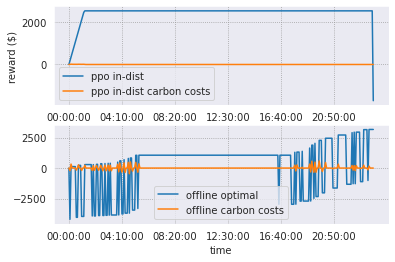

In [6]:
env = BatteryStorageInGridEnv(month='2019-05', seed=195)
ppo = PPO.load('examples/model_2019_5.zip')

ax, ax2 = plot_reward_over_episode(None, ppo, env)

plt.savefig('reward_over_epsiode.png', dpi=300)